<a href="https://colab.research.google.com/github/deepankar5/-Triplet-Extractor-from-Wikipedia-page/blob/main/triple_extaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install Wikipedia-API

  Created wheel for Wikipedia-API: filename=Wikipedia_API-0.5.4-cp36-none-any.whl size=13462 sha256=f02fd4aac784f064e235507061d2bb511520753f386b4752ce7575fdabd51d60
  Stored in directory: /root/.cache/pip/wheels/bf/40/42/ba1d497f3712281b659dd65b566fc868035c859239571a725a
Successfully built Wikipedia-API


In [2]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI
)

p_wiki = wiki_wiki.page("Thor")
print(p_wiki.text)

In Germanic mythology, Thor (; from Old Norse: Þórr) is a hammer-wielding god associated with lightning, thunder, storms, sacred groves and trees, strength, the protection of mankind and also hallowing and fertility. Besides Old Norse Þórr, extensions of the god occur in Old English as Þunor and in Old High German as Donar. All forms of the deity stem from a Common Germanic *Þunraz (meaning 'thunder'). 
Thor is a prominently mentioned god throughout the recorded history of the Germanic peoples, from the Roman occupation of regions of Germania, to the Germanic expansions of the Migration Period, to his high popularity during the Viking Age, when, in the face of the process of the Christianization of Scandinavia, emblems of his hammer, Mjölnir, were worn and Norse pagan personal names containing the name of the god bear witness to his popularity.
Due to the nature of the Germanic corpus, narratives featuring Thor are only attested in Old Norse, where Thor appears throughout Norse mytholo

In [41]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip().replace('\n', ' ') for sent in document.sents]


In [72]:
nlp_model = spacy.load('en_core_web_sm')

def appendChunk(original):
    return original 

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object_ = ''
    relation = ''
    for token in tokens:
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = token
        if "subj" in token.dep_:
            subject = token
        if "obj" in token.dep_:
            object_ = token

    return (subject, relation, object_)

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

In [73]:
import pandas as pd
sentences = getSentences(p_wiki.text)
triples = []

for sentence in sentences:
    triples.append(processSentence(sentence))

relations_table = pd.DataFrame(triples, index = range(0, len(triples)), columns = ['Subject', 'Relation', 'Object'])

In [76]:
relations_table.to_csv('relation_table.csv')

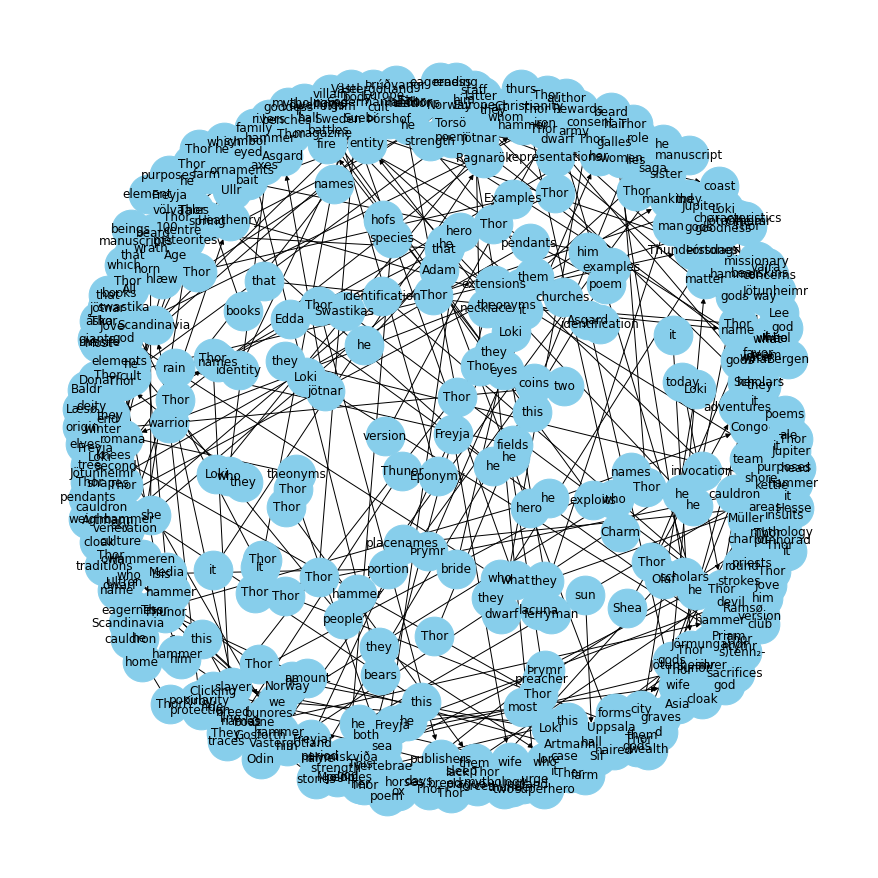

In [81]:
%matplotlib inline
G=nx.from_pandas_edgelist(relations_table, "Subject", "Object", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()